### Simulation Code 
Below is the code for simulation, it is the same with the testing code but all the checkpoints (print() functions) are deleted. 
With the testing code below, I ensured that I have a working code available for simulation and plotting graphs. 

In [1]:
import heapq
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

class AdditionalScreening(): 
    '''
    Represents additional screening handled by a single senior officer (shared amoung queues)
    The officer inspects travelers who trigger security alerts (3% chance).
    '''
    
    def __init__(self, screening_distribution):
        self.screening_queue = []  # Tracks travelers who need additional screening
        self.screening_time = [] # Record how long each passenger will be screened 
        self.screening_distribution = screening_distribution #The screening time distribution
        self.next_departure_time = np.inf  # When the officer is done screening

    def add_traveler(self, arrival_time):
        '''
        Adds a traveler to the queue and record the screening time they need.
        
        We generate and record screening time for each new traveler so we can 
        calculate the expected time they will depart (their arrival time + all
        the screening time travelers in front of them need) and report to their queue.
        '''
        # Push the item arrival time to the priority queue 
        heapq.heappush(self.screening_queue, arrival_time)
        # Push the needed service time for this traveler to the priority queue
        heapq.heappush(self.screening_time, self.screening_distribution.rvs()) 

        # If we went from an empty queue to 1 person
        if len(self.screening_queue) == 1:
            # Sanity check
            assert self.next_departure_time == np.inf
            # Generate the next departure time (because it is currently infinity).
            self.next_departure_time = arrival_time + self.screening_time[0] 

    def serve_traveler(self):
        '''
        Pops out a traveler from the front of the queue and remove their recorded screening time.
        '''

        # Remove the traveler that is screened
        heapq.heappop(self.screening_queue)
        # Remove their correspondent screening time
        heapq.heappop(self.screening_time)
        
        if len(self.screening_queue) == 0:
            # The queue is empty so we should not generate a new departure time.
            self.next_departure_time = np.inf
        else:
            # Generate the next departure time
            self.next_departure_time += self.screening_time[0]

    def request_screening(self, arrival_time):
        '''
        Adds the new traveler to the queue and check if there is any departures. 
        '''
        if arrival_time < self.next_departure_time:   
            # Handle arrivals
            self.add_traveler(arrival_time)
        else:
            # Handle departures
            while arrival_time > self.next_departure_time:
                self.serve_traveler()
        
        # Sanity check 
        assert len(self.screening_queue) >= 0 
        
        # Return the time the traveler needs to wait for them and every one in front 
        # of them to finish the additional screening to their queue
        return sum(self.screening_time)

class Queue:
    def __init__(self, service_distribution, senior_officer):
        self.priority_queue = []  # Tracks people in the queue
        self.service_distribution = service_distribution # The service time distribution
        self.senior_officer = senior_officer # Pass in access to AdditionalScreening()
        self.next_service_time = 0 # The time when the previous person departs and the next is being served
        self.next_departure_time = np.inf  # Tracks when travelers depart
        
        # For simuation purpose
        self.queue_length_history = [] # Tracks the queue length at every arrival
        self.wait_time_history = [] # Tracks the waiting time for each traveler
        self.run_until = np.inf # Update when we receive the length for simulation (when to stop)

    def add_traveler(self, arrival_time):
        '''
        Adds a traveler to the queue and starts service if idle.
        '''
                
        # Push the traveler (by their arrival time) to the priority queue
        heapq.heappush(self.priority_queue, arrival_time) 
        
        # Record the current queue length
        self.queue_length_history.append(len(self.priority_queue))
        
        if len(self.priority_queue) == 1:
            # If we went from an empty queue to 1 person and immidiately start serving
            # Generate the next departure time (because it is currently infinity).

            self.next_service_time = arrival_time # Immidiately start serving
            self.next_departure_time = arrival_time + self.service_distribution.rvs()
        
    def serve_traveler(self):
        '''
        Pops out a traveler from the front of the queue and record their waiting time.
        '''
        
        # Remove the traveler from the front of the queue
        arrival_time = heapq.heappop(self.priority_queue)
        # Record the time they have waited
        self.wait_time_history.append(self.next_service_time - arrival_time)
        
        # 3% chance of needing additional screening
        if np.random.rand() < 0.03:
            # Pass the traveler and their original departure time (= their arrival time in the 
            # additional screening queue) to request_screening() function. And update the departure
            # time of the traveler after their inspection
            self.next_departure_time += self.senior_officer.request_screening(self.next_departure_time)

        # Stop serving if the next departure time will exceed time of simulation
        if self.next_departure_time > self.run_until:
            return
        
        if len(self.priority_queue) == 0:
            # The queue is empty so we should not generate a new departure time.
            self.next_departure_time = np.inf

        else:
            # One travler departs and immidiately start serving the next 
            self.next_service_time = self.next_departure_time 
            # Generate the next departure time
            self.next_departure_time += self.service_distribution.rvs()

    def join_queue(self, arrival_time):
        '''
        Adds the new traveler to the queue and check if there is any departures. 
        '''
        if arrival_time < self.next_departure_time:   
            # Handle arrivals
            self.add_traveler(arrival_time)
        else:
            # Handle departures
            while arrival_time > self.next_departure_time:
                if self.next_departure_time > self.run_until:
                    return
                self.serve_traveler()
        
        assert len(self.priority_queue) >= 0  # Sanity check

class Airport:
    def __init__(self, arrival_distribution, service_distribution, additional_screening_distribution, num_of_queues):
        # Pass in distributions of arrival, service, and additional screening time
        self.arrival_distribution = arrival_distribution 
        self.service_distribution = service_distribution
        self.additional_screening_distribution = additional_screening_distribution
        
        # Initiate 1 additional screening queue
        self.senior_officer = AdditionalScreening(additional_screening_distribution)
        # Initiate n Queue()
        self.queues = [Queue(service_distribution, self.senior_officer) for _ in range(num_of_queues)]

    def get_least_busy_queue_index(self):
        '''
        Returns the index of the queue with the least elements in priority_queue.
        '''
        # Generate a list contains the length of the priority_queue in each Queue()
        queue_lengths = [len(queue.priority_queue) for queue in self.queues]
        
        # Return the index of the minimun 
        return np.argmin(queue_lengths) 
    
    def handle_arrival(self, arrival_time):
        '''
        Handles the arrival of a traveler by placing them in the least busy queue.
        '''
        # Get the index of the least busy queue
        least_busy_index = self.get_least_busy_queue_index() 
        # Add the traveler into the queue
        self.queues[least_busy_index].join_queue(arrival_time) 
        
    def get_queue_histories(self):
        '''
        Returns two lists containing queue_length_history and wait_time_history for each queue.
        '''
        # Generate a list contains the history of queue length in each Queue()
        queue_lengths = [queue.queue_length_history for queue in self.queues]
        # Generate a list contains the record of waiting time in each Queue()
        wait_times = [queue.wait_time_history for queue in self.queues]
        return queue_lengths, wait_times
        
    def run(self, run_until):
        '''
        Runs the simulation until the specified time.
        Returns two lists containing queue_length_history and wait_time_history for each queue.
        '''
        # Update when to stop the simulation for each queue
        for queue in self.queues:
            queue.run_until = run_until
            
        # Generate the first arrival
        new_arrival_time = self.arrival_distribution.rvs()

        # Check if we ran out of time
        while new_arrival_time < run_until: 
            self.handle_arrival(new_arrival_time) # Accept the new arrival
            new_arrival_time += self.arrival_distribution.rvs() # Generate a new arrival time 
                
        # Return two lists (queue length and waiting time) for further analysis
        return self.get_queue_histories()

### Simulation of Key Performance Indicators
Below is the code for generating distributions (histogram) of average queue length in a day, maximum queue length in a day, and average waiting time in a day for 1000 simulations. This helps me examine the two equilibrium states I found and compare them with each other and the theoretical analysis.

In [72]:
# Plotting the graphs for key performance indicators including 
# average queue length, maximum queue length, and average waiting times.

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_simulations(num_simulations, run_until, num_queues):
    
    # Store results
    all_queue_lengths = []
    all_max_lengths = []
    all_wait_times = []
    
    # Parameters
    arrival_rate = 10
    service_rate = 2
    
    # Service time distribution parameters
    mean_service = 1/service_rate
    sigma_service = 1/6
    a_service = (0 - mean_service) / sigma_service
    b_service = np.inf
    
    # Additional screening parameters
    mean_as = 2
    sigma_as = 2
    a_as = (0 - mean_as) / sigma_as
    b_as = np.inf
    
    # Create distributions
    arrival_distribution = sts.expon(scale=1/arrival_rate)
    service_distribution = sts.truncnorm(a_service, b_service, loc=mean_service, scale=sigma_service)
    additional_screening_distribution = sts.truncnorm(a_as, b_as, loc=mean_as, scale=sigma_as)
    
    # Set up progress bar to track simulation
    progress_bar = tqdm(total=num_simulations, desc = f"{num_queues} Queues") 

    for sim in range(num_simulations):
        # Create new airport instance for each simulation
        airport = Airport(arrival_distribution, service_distribution, 
                         additional_screening_distribution, num_queues)
        
        # Run simulation
        queue_lengths, wait_times = airport.run(run_until)
        
        # Process key indicators into lists
        avg_lengths = [np.mean(lengths) for lengths in queue_lengths]
        max_lengths = [np.max(lengths) for lengths in queue_lengths]
        avg_waits = [np.mean(times) for times in wait_times]
        
        # Record the lists 
        all_queue_lengths.extend(avg_lengths)
        all_max_lengths.extend(max_lengths)
        all_wait_times.extend(avg_waits)
        
        # Update tqdm
        progress_bar.update(1)
    
    return all_queue_lengths, all_max_lengths, all_wait_times

def calculate_population_ci(data, confidence=0.95):
    '''
    Calculate mean and population confidence interval.
    '''
    mean = np.mean(data)
    std = np.std(data)
    
    # For population interval, we use normal distribution quantiles
    z_score = sts.norm.ppf((1 + confidence) / 2)
    margin = z_score * std
    
    # Calculate interval that contains confidence% of the population
    ci_lower = mean - margin
    ci_upper = mean + margin
    
    return mean, (ci_lower, ci_upper)

def plot_results(queue_lengths, max_lengths, wait_times, num_queues):
    # Calculate confidence intervals and means
    ql_mean, ql_ci = calculate_population_ci(queue_lengths)
    ml_mean, ml_ci = calculate_population_ci(max_lengths)
    wt_mean, wt_ci = calculate_population_ci(wait_times)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot average queue lengths
    ax1.hist(queue_lengths, bins=30, edgecolor='black', alpha=0.7)
    ax1.axvline(ql_mean, color='r', linestyle='--', label=f'Mean: {ql_mean:.2f}')
    ax1.axvline(ql_ci[0], color='g', linestyle=':', label=f'95% CI: [{ql_ci[0]:.2f}, {ql_ci[1]:.2f}]')
    ax1.axvline(ql_ci[1], color='g', linestyle=':')
    ax1.set_title(f'Average Queue Lengths with {num_queues} Queues in a Day')
    ax1.set_xlabel('Average Queue Length')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # Plot maximum queue lengths
    ax2.hist(max_lengths, bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(ml_mean, color='r', linestyle='--', label=f'Mean: {ml_mean:.2f}')
    ax2.axvline(ml_ci[0], color='g', linestyle=':', label=f'95% CI: [{ml_ci[0]:.2f}, {ml_ci[1]:.2f}]')
    ax2.axvline(ml_ci[1], color='g', linestyle=':')
    ax2.set_title(f'Maximum Queue Lengths with {num_queues} Queues in a Day')
    ax2.set_xlabel('Maximum Queue Length')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # Plot average waiting times
    ax3.hist(wait_times, bins=30, edgecolor='black', alpha=0.7)
    ax3.axvline(wt_mean, color='r', linestyle='--', label=f'Mean: {wt_mean:.2f}')
    ax3.axvline(wt_ci[0], color='g', linestyle=':', label=f'95% CI: [{wt_ci[0]:.2f}, {wt_ci[1]:.2f}]')
    ax3.axvline(wt_ci[1], color='g', linestyle=':')
    ax3.set_title(f'Average Waiting Times with {num_queues} Queues in a Day')
    ax3.set_xlabel('Average Wait Time (minutes)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return confidence intervals for summary statistics
    return (ql_mean, ql_ci), (ml_mean, ml_ci), (wt_mean, wt_ci)


Starting simulations...


7 Queues: 100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


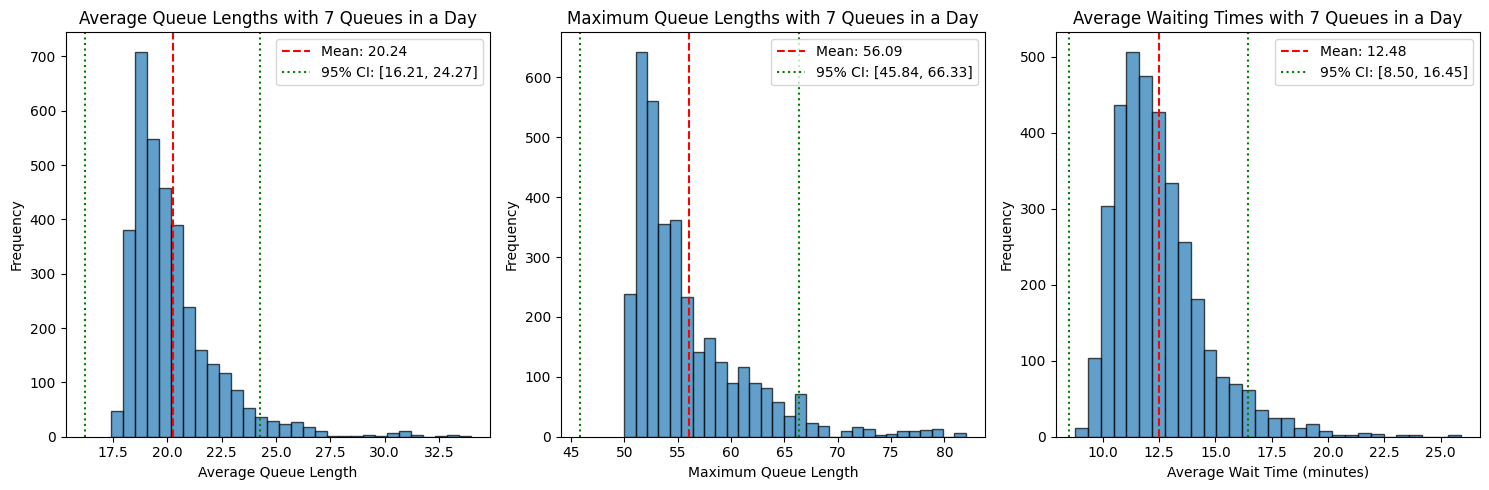


Detailed Summary Statistics:

Average Queue Length:
  Mean: 20.24
  95% Population Interval: [16.21, 24.27]
  Standard Deviation: 2.06

Maximum Queue Length:
  Mean: 56.09
  95% Population Interval: [45.84, 66.33]
  Standard Deviation: 5.23

Average Waiting Time (minutes):
  Mean: 12.48
  95% Population Interval: [8.50, 16.45]
  Standard Deviation: 2.03


In [ ]:
# For queue length = 7

# Run simulations (keeping your existing run_simulations function)
print("Starting simulations...")
num_simulations = 500
run_until = 60*24  # One day (60 mins * 24)
num_queues = 7
queue_lengths, max_lengths, wait_times = run_simulations(num_simulations, run_until, num_queues)

# Plot results and get confidence intervals
ql_stats, ml_stats, wt_stats = plot_results(queue_lengths, max_lengths, wait_times, num_queues)

# Print detailed summary statistics
print("\nDetailed Summary Statistics:")
print("\nAverage Queue Length:")
print(f"  Mean: {ql_stats[0]:.2f}")
print(f"  95% CI: [{ql_stats[1][0]:.2f}, {ql_stats[1][1]:.2f}]")

print("\nMaximum Queue Length:")
print(f"  Mean: {ml_stats[0]:.2f}")
print(f"  95% CI: [{ml_stats[1][0]:.2f}, {ml_stats[1][1]:.2f}]")

print("\nAverage Waiting Time (minutes):")
print(f"  Mean: {wt_stats[0]:.2f}")
print(f"  95% CI: [{wt_stats[1][0]:.2f}, {wt_stats[1][1]:.2f}]")

Starting simulations...


10 Queues: 100%|██████████| 500/500 [05:59<00:00,  1.39it/s]


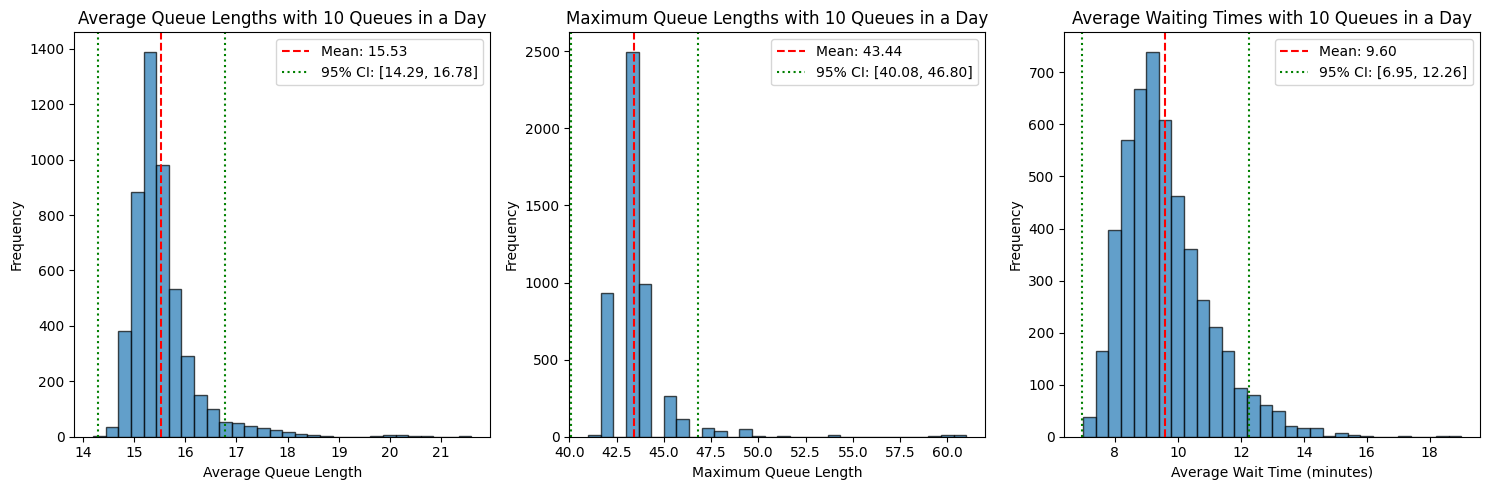


Detailed Summary Statistics:

Average Queue Length:
  Mean: 15.53
  95% Population Interval: [14.29, 16.78]
  Standard Deviation: 0.64

Maximum Queue Length:
  Mean: 43.44
  95% Population Interval: [40.08, 46.80]
  Standard Deviation: 1.72

Average Waiting Time (minutes):
  Mean: 9.60
  95% Population Interval: [6.95, 12.26]
  Standard Deviation: 1.36


In [ ]:
# For queue length = 10

# Run simulations (keeping your existing run_simulations function)
print("Starting simulations...")
num_simulations = 500
run_until = 60*24  # One day (60 mins * 24)
num_queues = 10
queue_lengths, max_lengths, wait_times = run_simulations(num_simulations, run_until, num_queues)

# Plot results and get confidence intervals
ql_stats, ml_stats, wt_stats = plot_results(queue_lengths, max_lengths, wait_times, num_queues)

# Print detailed summary statistics
print("\nDetailed Summary Statistics:")
print("\nAverage Queue Length:")
print(f"  Mean: {ql_stats[0]:.2f}")
print(f"  95% CI: [{ql_stats[1][0]:.2f}, {ql_stats[1][1]:.2f}]")

print("\nMaximum Queue Length:")
print(f"  Mean: {ml_stats[0]:.2f}")
print(f"  95% CI: [{ml_stats[1][0]:.2f}, {ml_stats[1][1]:.2f}]")

print("\nAverage Waiting Time (minutes):")
print(f"  Mean: {wt_stats[0]:.2f}")
print(f"  95% CI: [{wt_stats[1][0]:.2f}, {wt_stats[1][1]:.2f}]")

### Simulation of a Day
Below is the code for generating plots of the queue length fluctuation and individual traveler's waiting time fluctuation in a day with 3 simulation. I did not pick to have many simulations so reduce the complexity of the visualization. The running time is 60 * 24, which is a day of 1440 minuets. 

In [2]:
# Plotting the fluctuation of queue length and waiting time in each simulation

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def run_and_plot_simulations(num_simulations, run_until, num_queues):
    # Parameters
    arrival_rate = 10
    service_rate = 2
    
    # Service time distribution parameters
    mean_service = 1/service_rate
    sigma_service = 1/6
    a_service = (0 - mean_service) / sigma_service
    b_service = np.inf
    
    # Additional screening parameters
    mean_as = 2
    sigma_as = 2
    a_as = (0 - mean_as) / sigma_as
    b_as = np.inf
    
    # Create distributions
    arrival_distribution = sts.expon(scale=1/arrival_rate)
    service_distribution = sts.truncnorm(a_service, b_service, loc=mean_service, scale=sigma_service)
    additional_screening_distribution = sts.truncnorm(a_as, b_as, loc=mean_as, scale=sigma_as)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Colors for different simulations
    colors = ['yellowgreen', 'orange', 'indianred']
    
    # Store maximum queue lengths
    max_lengths = []

    # Create legend elements for simulations
    legend_elements = [Patch(facecolor=color, alpha=0.3, label=f'Simulation {i+1}')
                      for i, color in enumerate(colors)]
    
    for sim in range(num_simulations):
        print(f"Running simulation {sim + 1}...")
        
        # Create new airport instance
        airport = Airport(arrival_distribution, service_distribution, 
                         additional_screening_distribution, num_queues)
        
        # Run simulation
        queue_lengths, wait_times = airport.run(run_until)
        
        # Plot queue lengths for each queue
        for q in range(num_queues):
            # Create time points (one for each length measurement)
            time_points = np.linspace(0, run_until, len(queue_lengths[q]))
            
            # Plot queue lengths
            line = ax1.plot(time_points, queue_lengths[q], 
                          alpha=0.3, 
                          color=colors[sim])
            
            # Store and plot maximum
            max_length = np.max(queue_lengths[q])
            max_lengths.append(max_length)
            ax1.axhline(y=max_length, 
                       color=colors[sim], 
                       linestyle='--', 
                       alpha=0.2)
            
            # Plot wait times
            ax2.plot(range(len(wait_times[q])), 
                    wait_times[q], 
                    alpha=0.3,
                    color=colors[sim])

    # Add simulation color legend to both plots
    ax1.legend(handles=legend_elements, loc='upper left', title='Simulations')
    ax2.legend(handles=legend_elements, loc='upper left', title='Simulations')
    
    # Customize queue length plot
    ax1.set_title(f'Queue Lengths Over Time, With {num_queues} queues.', fontsize=14)
    ax1.set_xlabel('Time (minutes)', fontsize=12)
    ax1.set_ylabel('Queue Length', fontsize=12)
    
    ax1.grid(True, alpha=0.3)
    
    # Add text annotations for maximum queue lengths
    for i, max_len in enumerate(max_lengths):
        sim_num = i // num_queues + 1
        queue_num = i % num_queues + 1
        ax1.text(run_until * 0.8, max_len, 
                f'Max: {max_len:.0f}',
                color=colors[(i // num_queues)],
                alpha=0.7)
    
    # Customize wait times plot
    ax2.set_title(f'Wait Times for Each Traveler, With {num_queues} queues.', fontsize=14)
    ax2.set_xlabel('Traveler Number', fontsize=12)
    ax2.set_ylabel('Wait Time (minutes)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    
    plt.tight_layout()
    plt.show()

Running simulation 1...
Running simulation 2...
Running simulation 3...


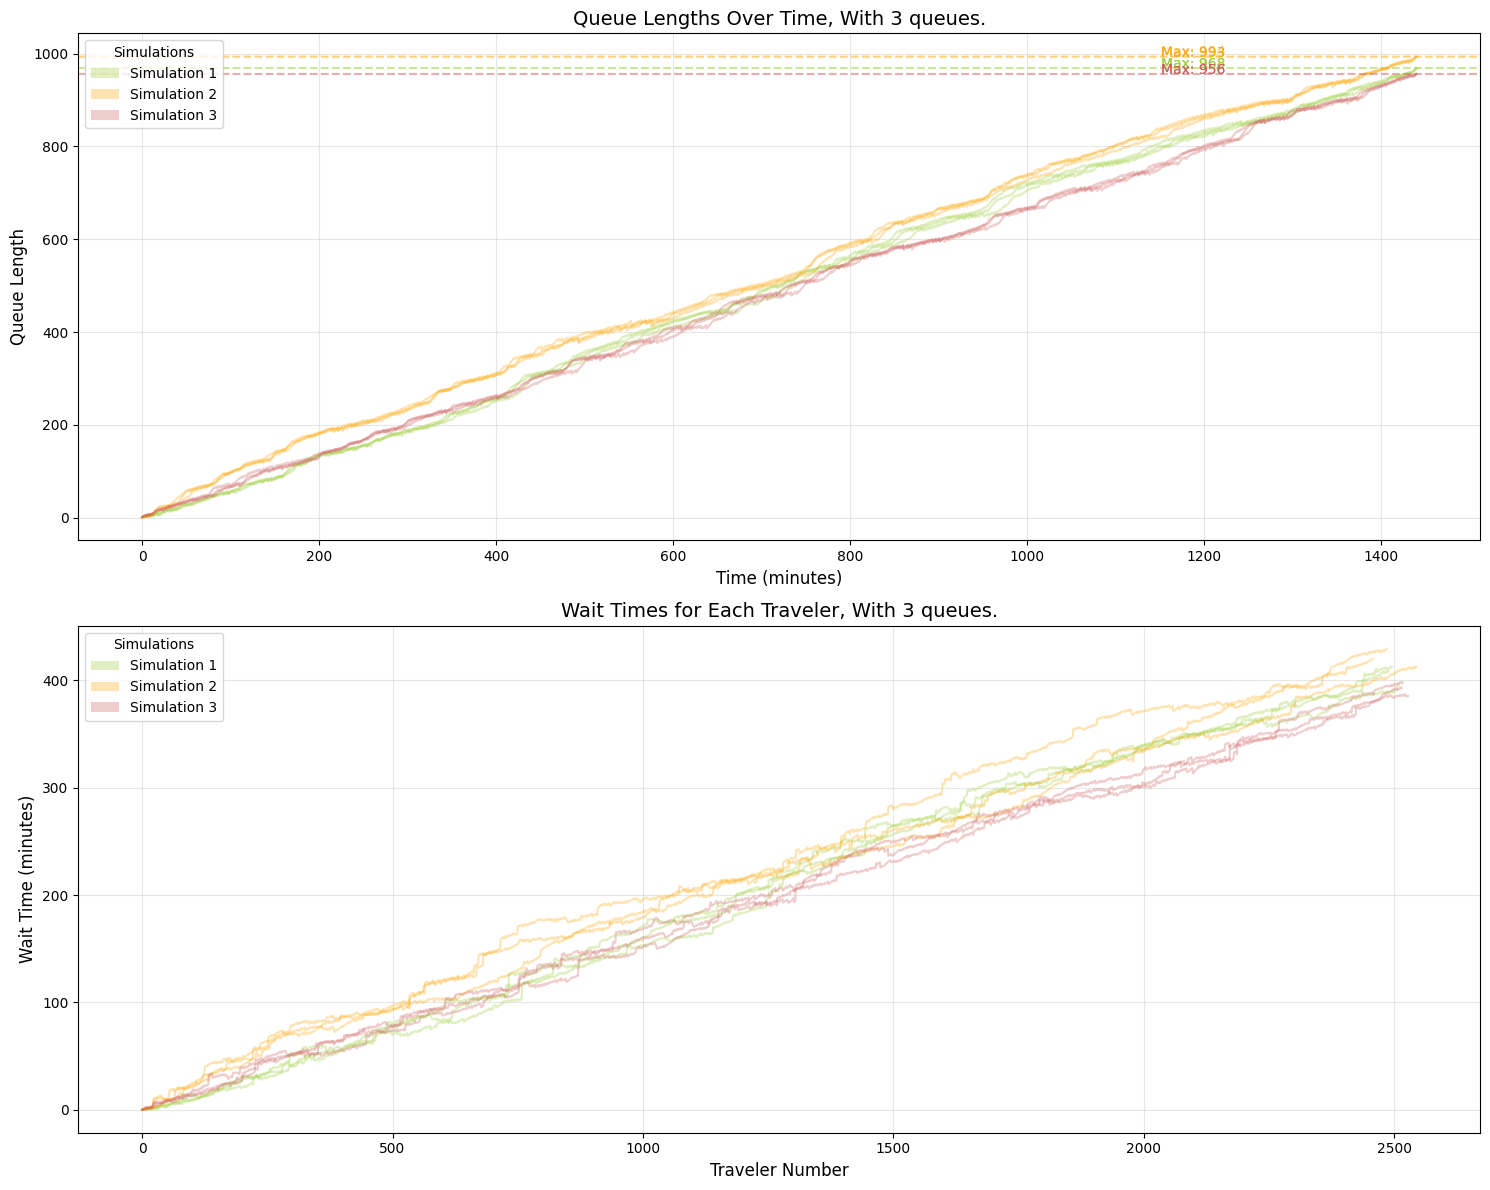

Running simulation 1...
Running simulation 2...
Running simulation 3...


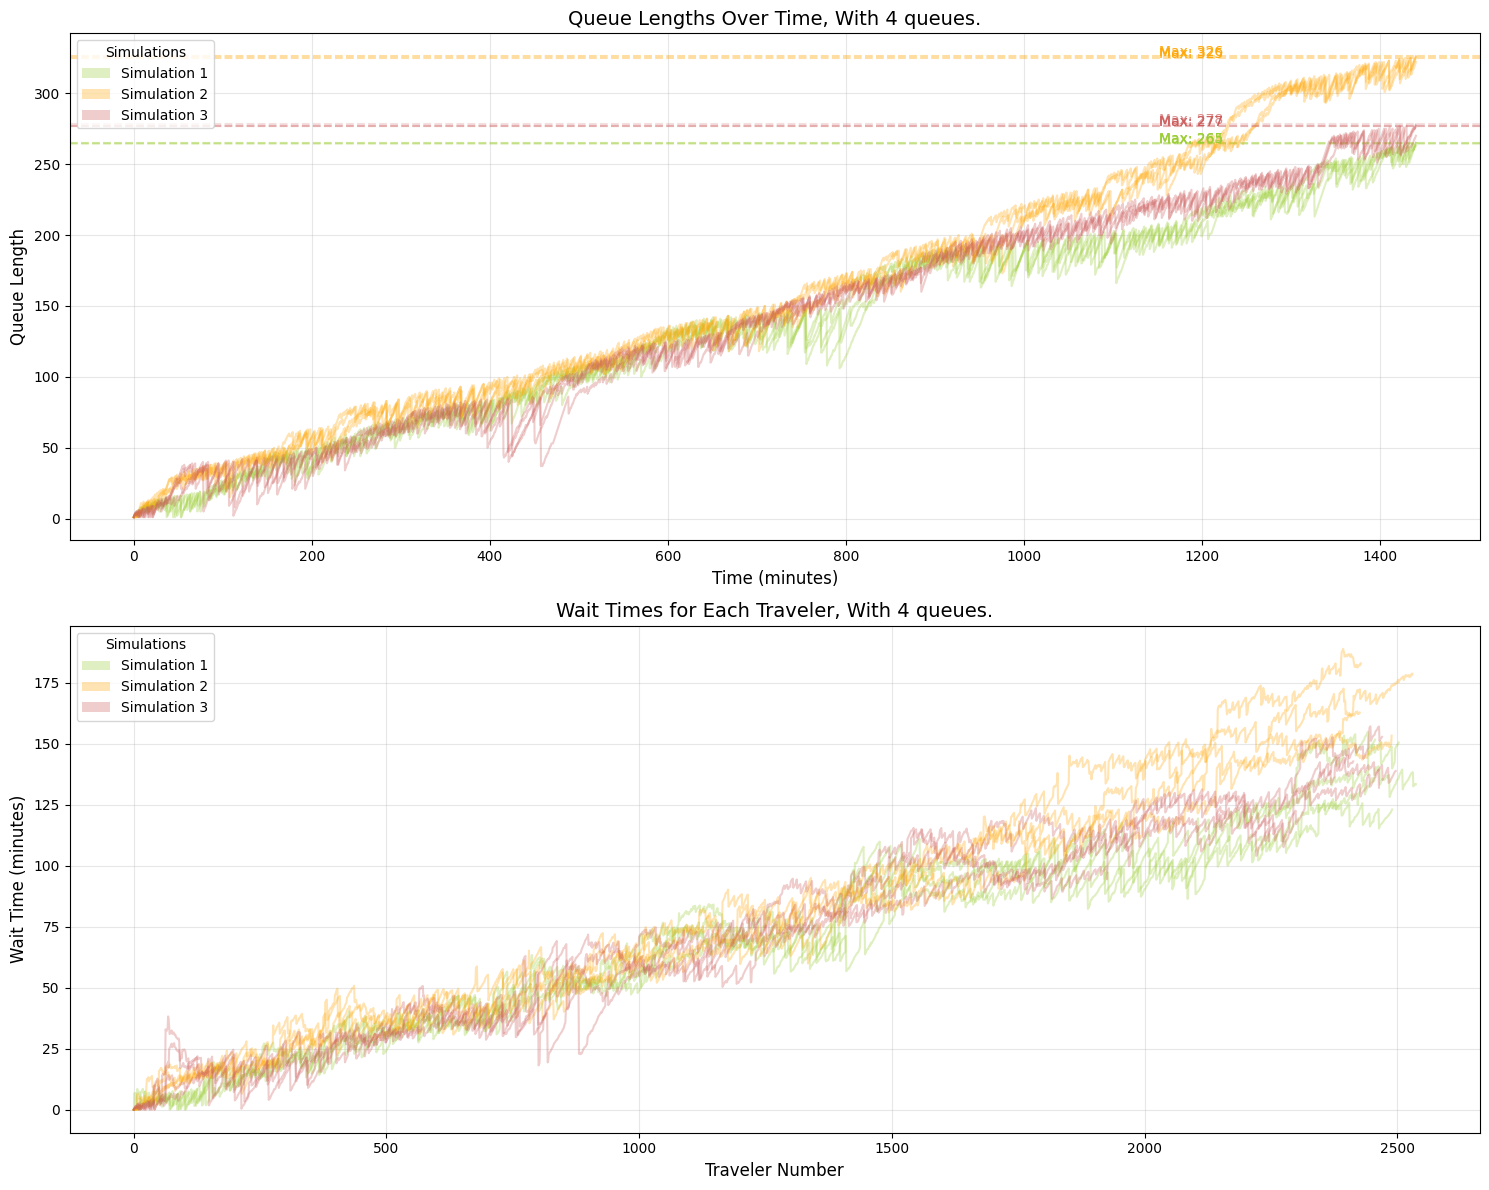

Running simulation 1...
Running simulation 2...
Running simulation 3...


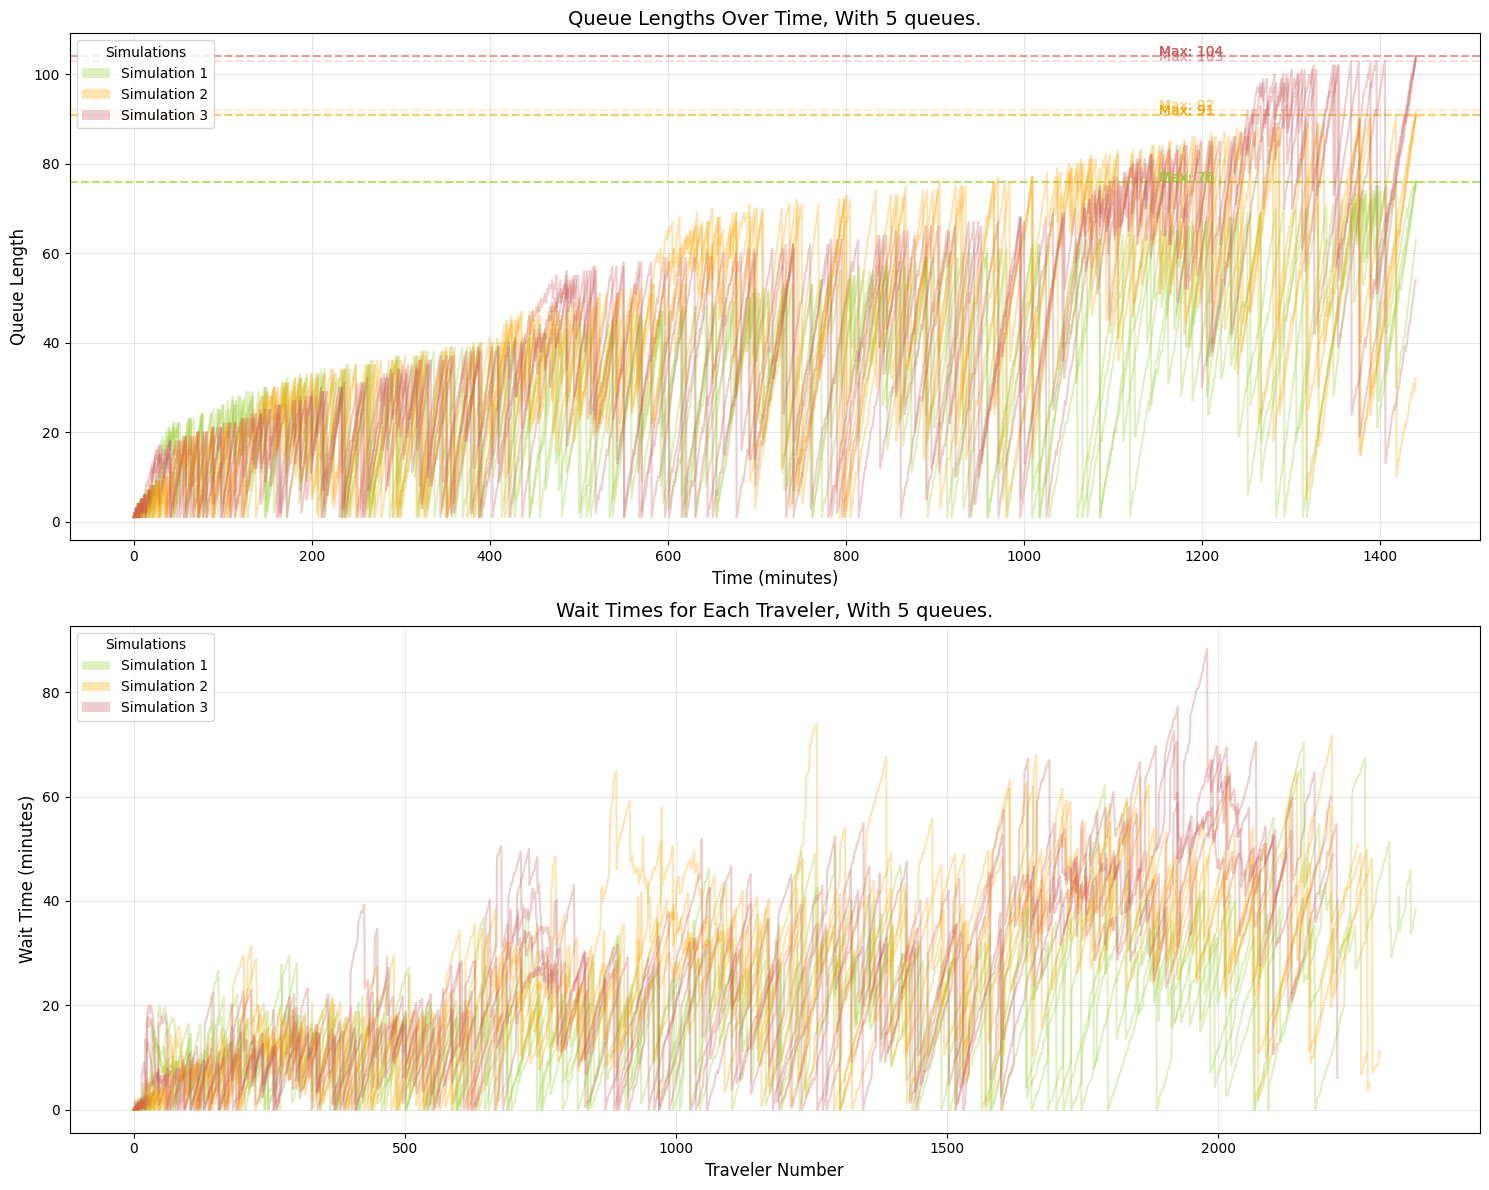

Running simulation 1...
Running simulation 2...
Running simulation 3...


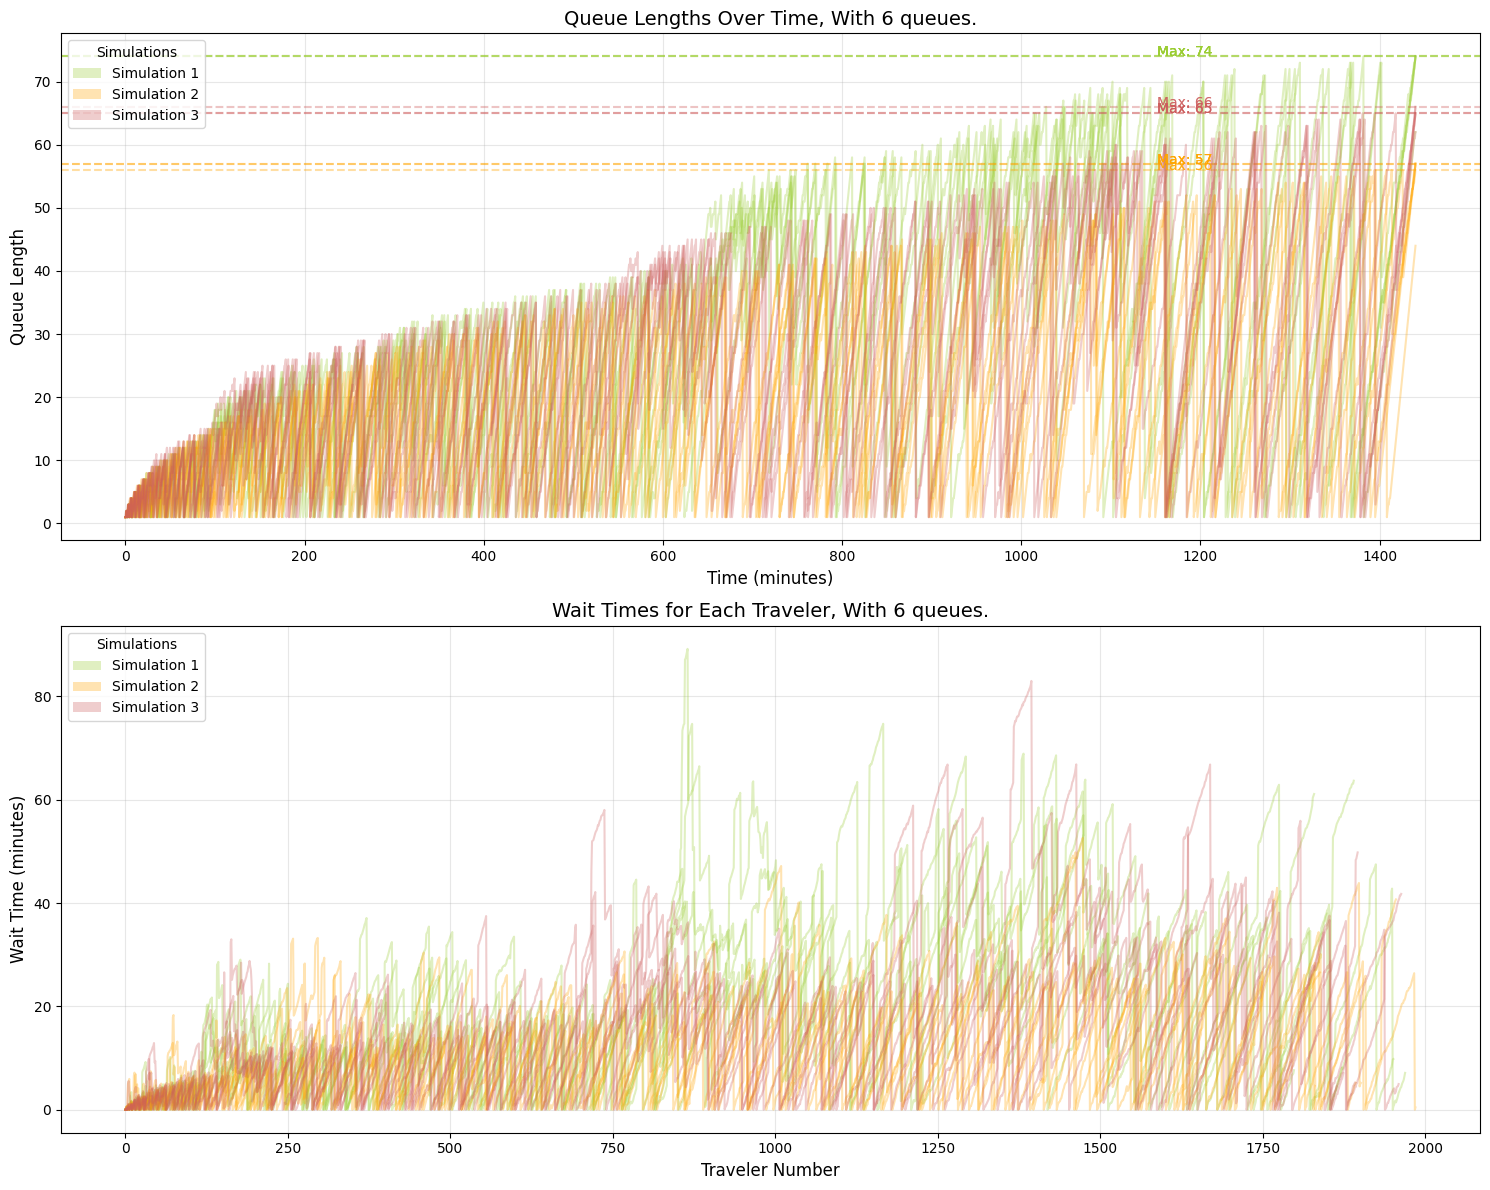

Running simulation 1...
Running simulation 2...
Running simulation 3...


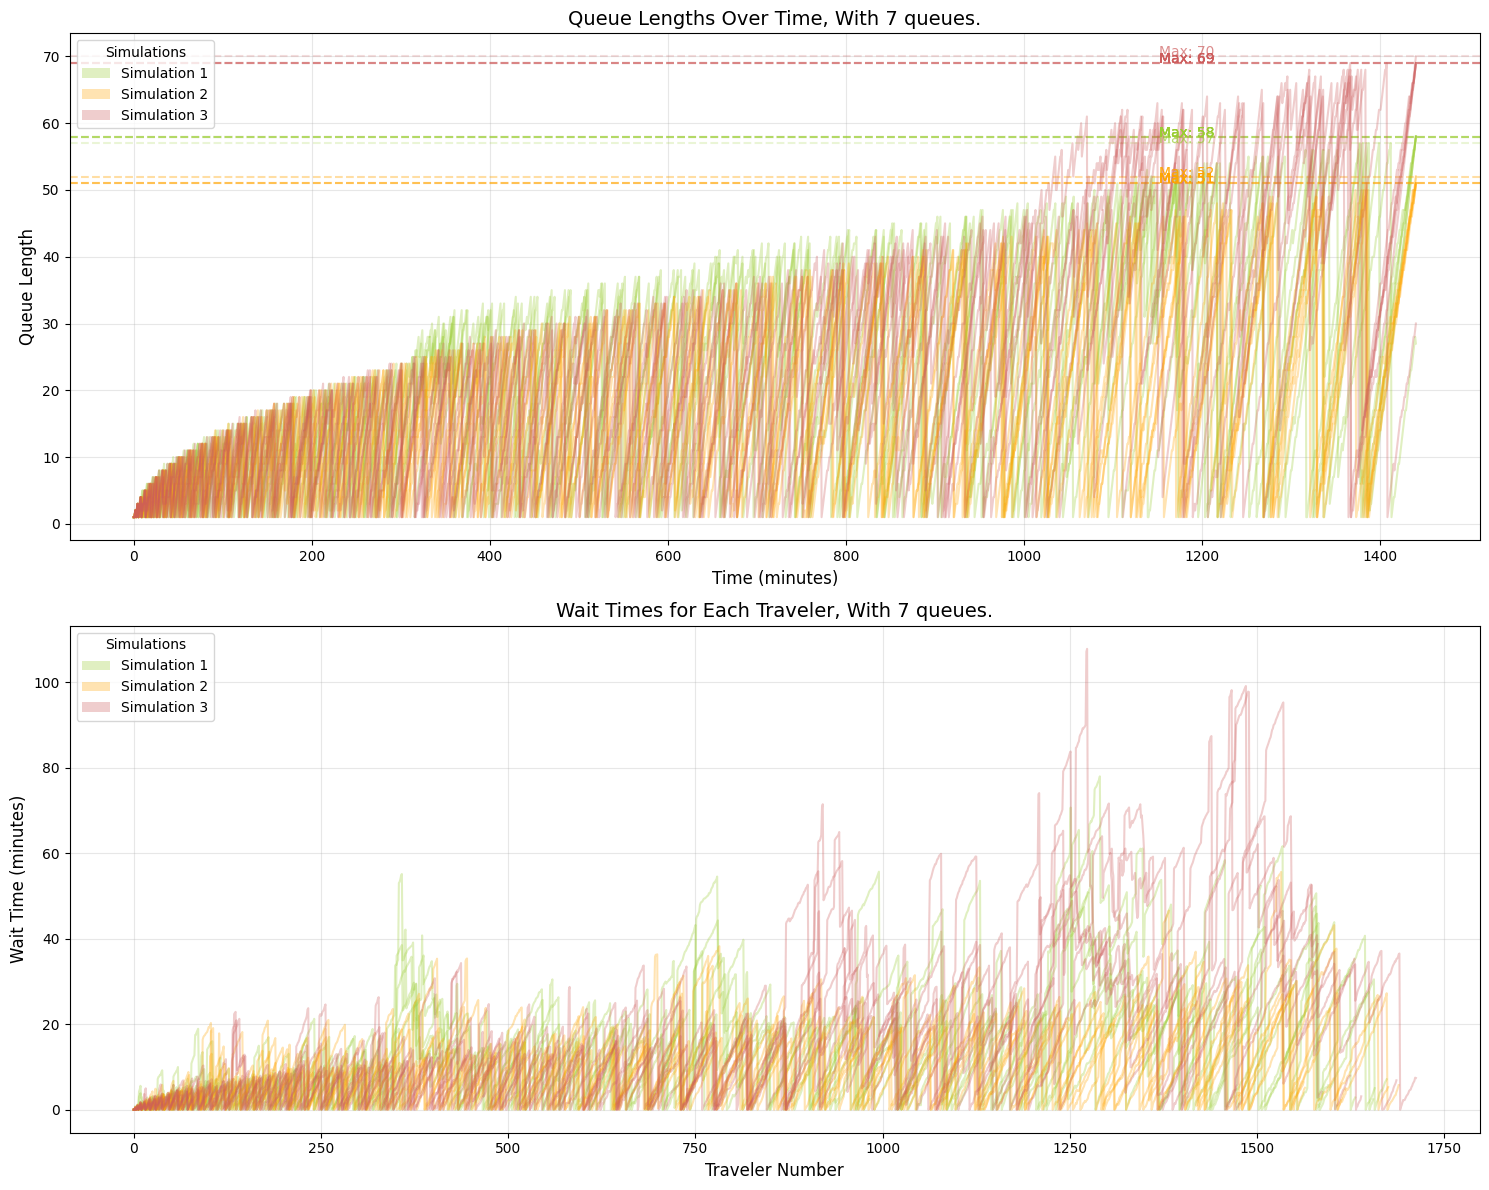

Running simulation 1...
Running simulation 2...
Running simulation 3...


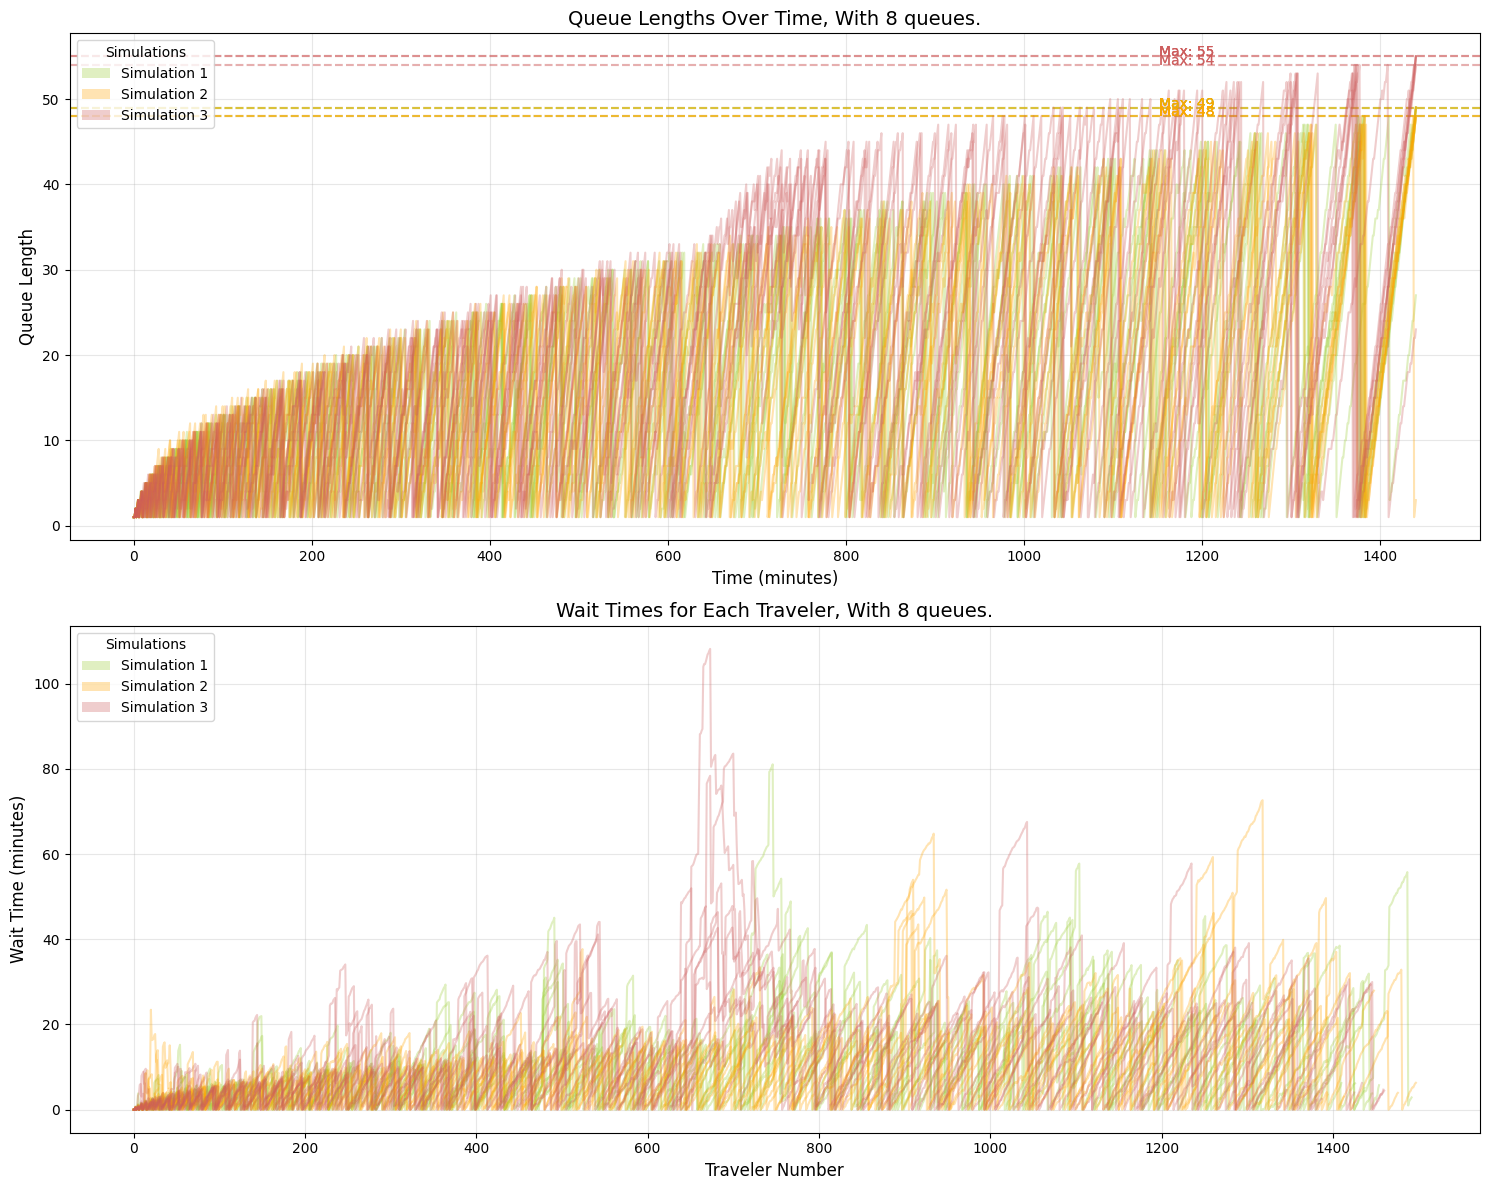

Running simulation 1...
Running simulation 2...
Running simulation 3...


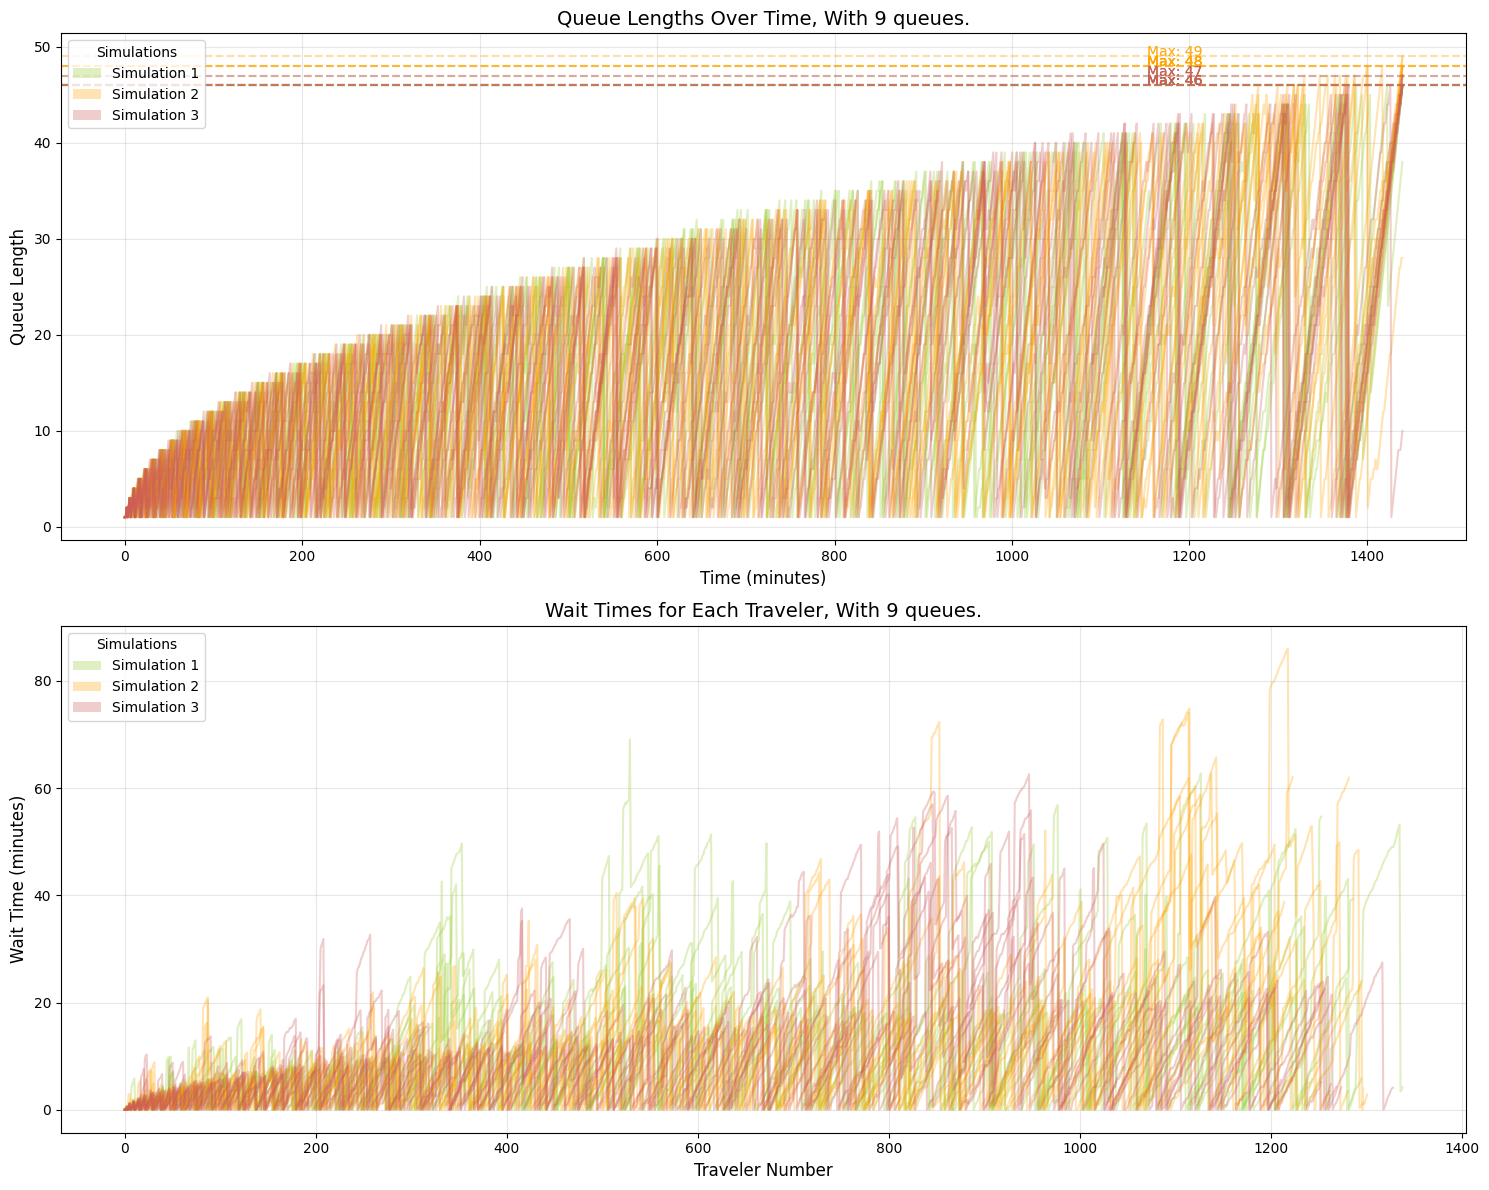

Running simulation 1...
Running simulation 2...
Running simulation 3...


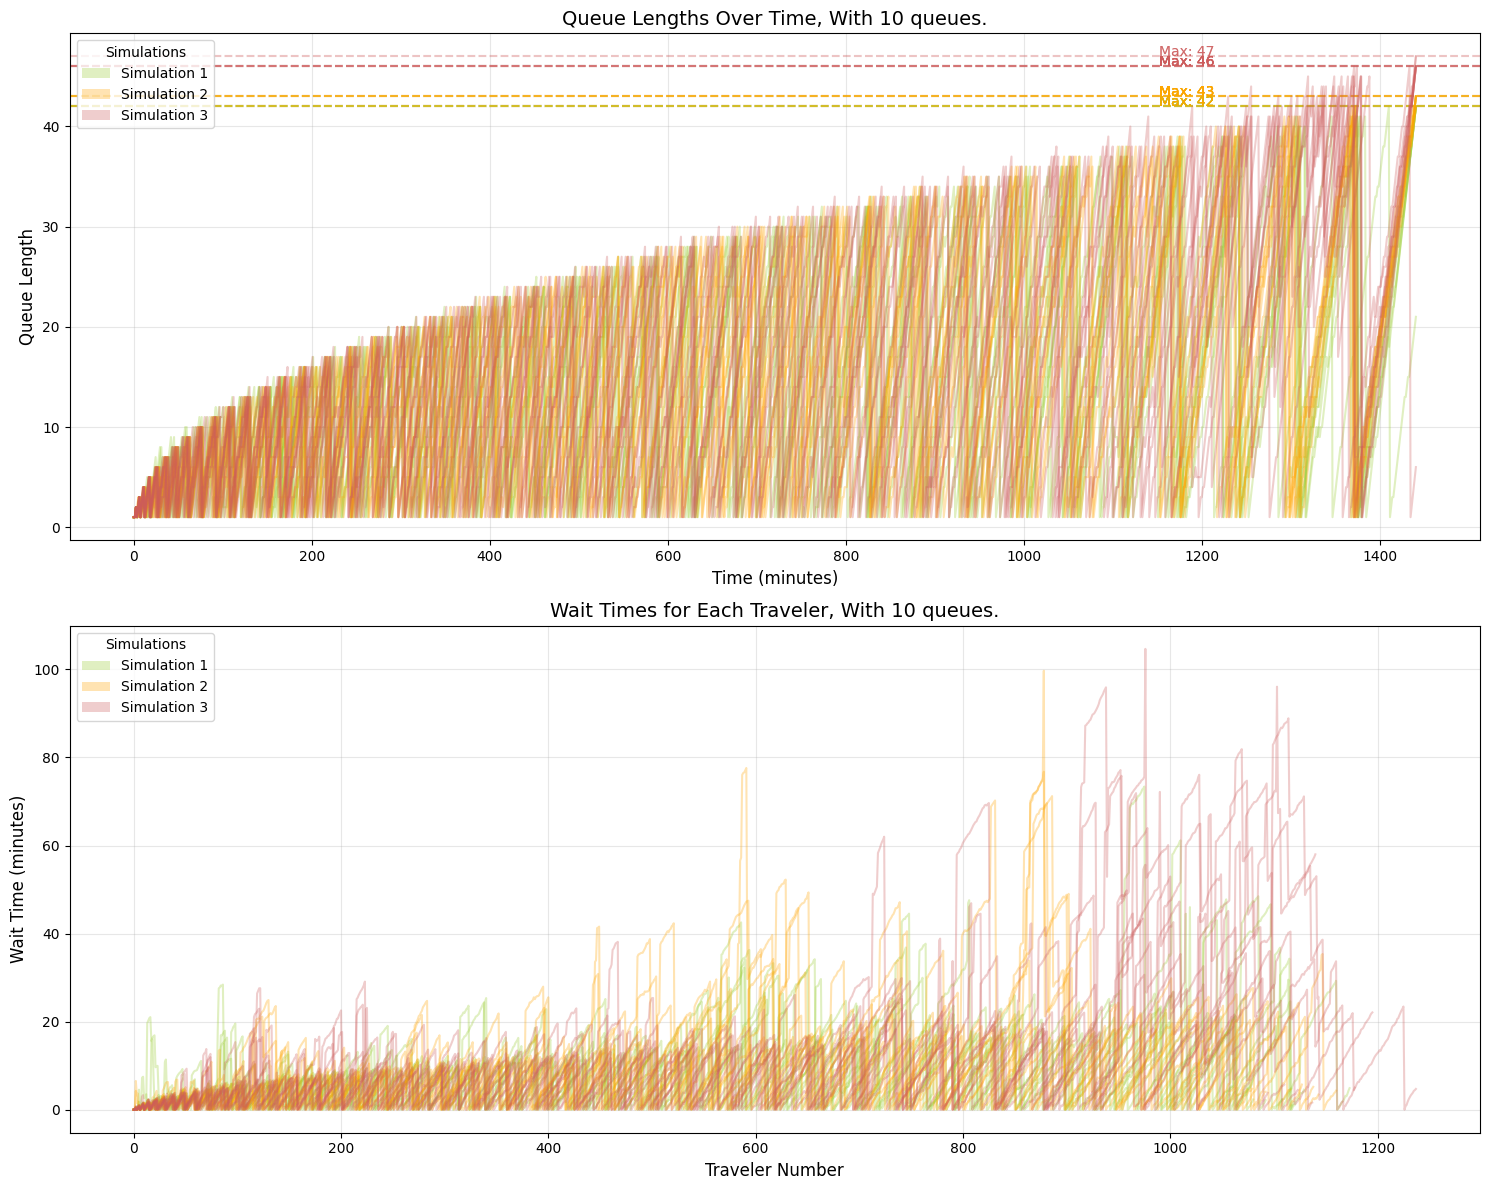

In [3]:
# Run the simulation and create plots
for num_queues in range(3, 11):
    num_simulations=3
    run_until=60*24 #1 DAYS
    run_and_plot_simulations(num_simulations, run_until, num_queues)

### Testing Code 
Below is the code for testing, it is the same with the simulation code but includes print() functions that show each step the system takes. 
This is to ensure that there is a working code available for simulation and that the code functions exactly how we want it to. 

In [75]:
import heapq
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

class AdditionalScreening(): 
    '''
    Represents additional screening handled by a single senior officer (shared amoung queues)
    The officer inspects travelers who trigger security alerts (3% chance).
    '''
    
    def __init__(self, screening_distribution):
        self.screening_queue = []  # Tracks travelers who need additional screening
        self.screening_time = [] # Record how long each passenger will be screened 
        self.screening_distribution = screening_distribution #The screening time distribution
        self.next_departure_time = np.inf  # When the officer is done screening

    def add_traveler(self, arrival_time):
        '''
        Adds a traveler to the queue and record the screening time they need.
        
        We generate and record screening time for each new traveler so we can 
        calculate the expected time they will depart (their arrival time + all
        the screening time travelers in front of them need) and report to their queue.
        '''
        # Push the item arrival time to the priority queue 
        heapq.heappush(self.screening_queue, arrival_time)
        # Push the needed service time for this traveler to the priority queue
        heapq.heappush(self.screening_time, self.screening_distribution.rvs()) 

        # Checkpoint
        print(f"❗👩‍✈️Traveler at {arrival_time} requires additional screening! There are {len(self.screening_queue)-1} people in the line and this will take {sum(self.screening_time)} minutes!")

        # If we went from an empty queue to 1 person
        if len(self.screening_queue) == 1:
            # Sanity check
            assert self.next_departure_time == np.inf
            # Generate the next departure time (because it is currently infinity).
            self.next_departure_time = arrival_time + self.screening_time[0] 

    def serve_traveler(self):
        '''
        Pops out a traveler from the front of the queue and remove their recorded screening time.
        '''

        # Remove the traveler that is screened
        heapq.heappop(self.screening_queue)
        # Remove their correspondent screening time
        heapq.heappop(self.screening_time)
        
        if len(self.screening_queue) == 0:
            # The queue is empty so we should not generate a new departure time.
            self.next_departure_time = np.inf
        else:
            # Generate the next departure time
            self.next_departure_time += self.screening_time[0]

    def request_screening(self, arrival_time):
        '''
        Adds the new traveler to the queue and check if there is any departures. 
        '''
        if arrival_time < self.next_departure_time:   
            # Handle arrivals
            self.add_traveler(arrival_time)
        else:
            # Handle departures
            while arrival_time > self.next_departure_time:
                self.serve_traveler()
        
        # Sanity check 
        assert len(self.screening_queue) >= 0 
        
        # Return the time the traveler needs to wait for them and every one in front 
        # of them to finish the additional screening to their queue
        return sum(self.screening_time)

class Queue:
    def __init__(self, service_distribution, senior_officer):
        self.priority_queue = []  # Tracks people in the queue
        self.service_distribution = service_distribution # The service time distribution
        self.senior_officer = senior_officer # Pass in access to AdditionalScreening()
        self.next_service_time = 0 # The time when the previous person departs and the next is being served
        self.next_departure_time = np.inf  # Tracks when travelers depart
        
        # For simuation purpose
        self.queue_length_history = [] # Tracks the queue length at every arrival
        self.wait_time_history = [] # Tracks the waiting time for each traveler
        self.run_until = np.inf # Update when we receive the length for simulation (when to stop)

    def add_traveler(self, arrival_time):
        '''
        Adds a traveler to the queue and starts service if idle.
        '''
        
        # Checkpoint
        print(f"🚶‍♂️🚶🚶‍♀️New arrival at {arrival_time}!")
        
        # Push the traveler (by their arrival time) to the priority queue
        heapq.heappush(self.priority_queue, arrival_time) 
        
        # Record the current queue length
        self.queue_length_history.append(len(self.priority_queue))
        
        if len(self.priority_queue) == 1:
            # If we went from an empty queue to 1 person and immidiately start serving
            # Generate the next departure time (because it is currently infinity).

            assert self.next_departure_time == np.inf  # Sanity check
            self.next_service_time = arrival_time # Immidiately start serving
            self.next_departure_time = arrival_time + self.service_distribution.rvs()
        
    def serve_traveler(self):
        '''
        Pops out a traveler from the front of the queue and record their waiting time.
        '''
        
        # Remove the traveler from the front of the queue
        arrival_time = heapq.heappop(self.priority_queue)
        # Record the time they have waited
        self.wait_time_history.append(self.next_service_time - arrival_time)
        
        # Checkpoint
        print(f"🕰️Start serving at {self.next_service_time}, this traveler waited {self.next_service_time - arrival_time} minutes!")

        # 3% chance of needing additional screening
        if np.random.rand() < 0.03:
            # Pass the traveler and their original departure time (= their arrival time in the 
            # additional screening queue) to request_screening() function. And update the departure
            # time of the traveler after their inspection
            self.next_departure_time += self.senior_officer.request_screening(self.next_departure_time)

        # Stop serving if the next departure time will exceed time of simulation
        if self.next_departure_time > self.run_until:
            return
        
        # Checkpoint
        print(f"🛫New departure at {self.next_departure_time}!")

        if len(self.priority_queue) == 0:
            # The queue is empty so we should not generate a new departure time.
            self.next_departure_time = np.inf
            # Checkpoint
            print(f"💤Queue empty!")

        else:
            # One travler departs and immidiately start serving the next 
            self.next_service_time = self.next_departure_time 
            # Generate the next departure time
            self.next_departure_time += self.service_distribution.rvs()

    def join_queue(self, arrival_time):
        '''
        Adds the new traveler to the queue and check if there is any departures. 
        '''
        if arrival_time < self.next_departure_time:   
            # Handle arrivals
            self.add_traveler(arrival_time)
        else:
            # Handle departures
            while arrival_time > self.next_departure_time:
                if self.next_departure_time > self.run_until:
                    print(f"🚧🚧This queue stopped because the next departure time is {self.next_departure_time}.🚧🚧")
                    return
                self.serve_traveler()
        
        assert len(self.priority_queue) >= 0  # Sanity check

class Airport:
    def __init__(self, arrival_distribution, service_distribution, additional_screening_distribution, num_of_queues):
        # Pass in distributions of arrival, service, and additional screening time
        self.arrival_distribution = arrival_distribution 
        self.service_distribution = service_distribution
        self.additional_screening_distribution = additional_screening_distribution
        
        # Initiate 1 additional screening queue
        self.senior_officer = AdditionalScreening(additional_screening_distribution)
        # Initiate n Queue()
        self.queues = [Queue(service_distribution, self.senior_officer) for _ in range(num_of_queues)]

    def get_least_busy_queue_index(self):
        '''
        Returns the index of the queue with the least elements in priority_queue.
        '''
        # Generate a list contains the length of the priority_queue in each Queue()
        queue_lengths = [len(queue.priority_queue) for queue in self.queues]
        
        # Return the index of the minimun 
        return np.argmin(queue_lengths) 
    
    def handle_arrival(self, arrival_time):
        '''
        Handles the arrival of a traveler by placing them in the least busy queue.
        '''
        # Get the index of the least busy queue
        least_busy_index = self.get_least_busy_queue_index() 
        # Add the traveler into the queue
        self.queues[least_busy_index].join_queue(arrival_time) 
        
        # Checkpoint
        print(f"➕➕➕Traveler joined queue {least_busy_index}.")

    def get_queue_histories(self):
        '''
        Returns two lists containing queue_length_history and wait_time_history for each queue.
        '''
        # Generate a list contains the history of queue length in each Queue()
        queue_lengths = [queue.queue_length_history for queue in self.queues]
        # Generate a list contains the record of waiting time in each Queue()
        wait_times = [queue.wait_time_history for queue in self.queues]
        return queue_lengths, wait_times
        
    def run(self, run_until):
        '''
        Runs the simulation until the specified time.
        Returns two lists containing queue_length_history and wait_time_history for each queue.
        '''
        # Update when to stop the simulation for each queue
        for queue in self.queues:
            queue.run_until = run_until
            
        # Generate the first arrival
        new_arrival_time = self.arrival_distribution.rvs()

        # Check if we ran out of time
        while new_arrival_time < run_until: 
            self.handle_arrival(new_arrival_time) # Accept the new arrival
            new_arrival_time += self.arrival_distribution.rvs() # Generate a new arrival time 
        
        # Checkpoint
        print(f'Stopped because next arrival time will be {new_arrival_time}.')
        
        # Return two lists (queue length and waiting time) for further analysis
        return self.get_queue_histories()

### Test Cases 
Test cases with different setups, showcasing that the code works under various settings.

In [ ]:
## Test case 1. -- with only 1 queue (so the timeline looks logical)

# Arrival rate and Service rate
arrival_rate = 10 #10 travelers per minute
service_rate = 2 #2 travelers per minute

## For Queue()
# Parameters for the service time distribution (truncated normal)
mean_service = 1/service_rate
sigma_service = 1/6 
a_service = (0 - mean_service) / sigma_service  # Standardized lower bound (0)
b_service = np.inf  # No upper bound (infinity)

## For AdditionalScreening()
# Parameters for the additional screening time distribution (truncated normal)
mean_as = 2
sigma_as = 2
a_as = (0 - mean_as) / sigma_as  # Standardized lower bound (0)
b_as = np.inf  # No upper bound (infinity)

# Create distributions
# Exponential inter-arrival time
arrival_distribution = sts.expon(scale=1/arrival_rate) 
# Truncated normal service time
service_distribution = sts.truncnorm(a_service, b_service, loc=mean_service, scale=sigma_service) 
# Truncated normal additional screening time
additional_screening_distribution = sts.truncnorm(a_as, b_as, loc=mean_as, scale=2)
num_of_queues = 1

# Create Airport() object
airport = Airport(arrival_distribution, service_distribution, additional_screening_distribution, num_of_queues)

# Run simulation
print(airport.run(10)) 

🚶‍♂️🚶🚶‍♀️New arrival at 0.3224884115540018!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.35887714747232363!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.4510664800688297!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.5396261938209723!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.8518170895206797!
➕➕➕Traveler joined queue 0.
🕰️Start serving at 0.3224884115540018, this traveler waited 0.0 minutes!
🛫New departure at 0.8739996018463574!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 1.051302838103852!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 1.1035715984653696!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 1.1218130732244358!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 1.1941992712025489!
➕➕➕Traveler joined queue 0.
🕰️Start serving at 0.8739996018463574, this traveler waited 0.5151224543740338 minutes!
🛫New departure at 1.256085091113896!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 1.3766425653058534!
➕➕➕Traveler join

In [ ]:
## Test case 2. -- very short time period (see if the system will stop itself when time runs out)

# Arrival rate and Service rate
arrival_rate = 10 #10 travelers per minute
service_rate = 4 #4 travelers per minute

## For Queue()
# Parameters for the service time distribution (truncated normal)
mean_service = 1/service_rate
sigma_service = 1/6  
a_service = (0 - mean_service) / sigma_service  # Standardized lower bound
b_service = np.inf  # No upper bound (infinity)

## For AdditionalScreening()
# Parameters for the additional screening time distribution (truncated normal)
mean_as = 2
sigma_as = 2
a_as = (0 - mean_as) / sigma_as  # Standardized lower bound
b_as = np.inf  # No upper bound (infinity)

# Create distributions
# Exponential inter-arrival time
arrival_distribution = sts.expon(scale=1/arrival_rate) 
# Truncated normal service time
service_distribution = sts.truncnorm(a_service, b_service, loc=mean_service, scale=sigma_service)
# Truncated normal additional screening time
additional_screening_distribution = sts.truncnorm(a_as, b_as, loc=mean_as, scale=2)
num_of_queues = 3

# Create Airport() object
airport = Airport(arrival_distribution, service_distribution, additional_screening_distribution, num_of_queues)

# Run simulation
print(airport.run(.5))

🚶‍♂️🚶🚶‍♀️New arrival at 0.10239960976115854!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.10692666110949214!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.17659616725140592!
➕➕➕Traveler joined queue 2.
🚶‍♂️🚶🚶‍♀️New arrival at 0.1823339875506727!
➕➕➕Traveler joined queue 0.
🕰️Start serving at 0.10692666110949214, this traveler waited 0.0 minutes!
🛫New departure at 0.24074642774139324!
💤Queue empty!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.3206510466179499!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.38848400271396977!
➕➕➕Traveler joined queue 1.
🕰️Start serving at 0.17659616725140592, this traveler waited 0.0 minutes!
🛫New departure at 0.21795649229081857!
💤Queue empty!
➕➕➕Traveler joined queue 2.
Stopped because next arrival time will be 0.5281866105634404.
([[1, 2], [1, 1, 2], [1]], [[], [np.float64(0.0)], [np.float64(0.0)]])


In [77]:
## Test case 3. -- When arrival_rate is a lot smaller than service_rate --> Little travelers and fast service

# Arrival rate and Service rate
arrival_rate = 3 #3 travelers per minute
service_rate = 6 #6 travelers per minute

## For Queue()
# Parameters for the service time distribution (truncated normal)
mean_service = 1/service_rate #1/6 minute per traveler
sigma_service = 1/6  
a_service = (0 - mean_service) / sigma_service  # Standardized lower bound
b_service = np.inf  # No upper bound (infinity)

## For AdditionalScreening()
# Parameters for the additional screening time distribution (truncated normal)
mean_as = 2
sigma_as = 2
a_as = (0 - mean_as) / sigma_as  # Standardized lower bound
b_as = np.inf  # No upper bound (infinity)

# Create distributions
# Exponential inter-arrival time
arrival_distribution = sts.expon(scale=1/arrival_rate)
# Truncated normal service time
service_distribution = sts.truncnorm(a_service, b_service, loc=mean_service, scale=sigma_service)
# Truncated normal additional screening time
additional_screening_distribution = sts.truncnorm(a_as, b_as, loc=mean_as, scale=2)
num_of_queues = 3

# Create Airport() object
airport = Airport(arrival_distribution, service_distribution, additional_screening_distribution, num_of_queues)

# Run simulation
print(airport.run(10))

🚶‍♂️🚶🚶‍♀️New arrival at 0.41894885807733495!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.8051734850777932!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 1.4640121920788824!
➕➕➕Traveler joined queue 2.
🕰️Start serving at 0.41894885807733495, this traveler waited 0.0 minutes!
🛫New departure at 0.5536395837794095!
💤Queue empty!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 2.3443366663944465!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 2.433940699013037!
➕➕➕Traveler joined queue 0.
🕰️Start serving at 0.8051734850777932, this traveler waited 0.0 minutes!
🛫New departure at 0.9442265611385235!
💤Queue empty!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 3.517149939465677!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 3.6298253996593224!
➕➕➕Traveler joined queue 1.
🕰️Start serving at 1.4640121920788824, this traveler waited 0.0 minutes!
🛫New departure at 1.5352316732165572!
💤Queue empty!
➕➕➕Traveler joined queue 2.
🚶‍♂️🚶🚶‍♀️New arrival at 3.97965019077

In [ ]:
# Test case 4. -- When arrival_rate is a lot larger than service_rate --> Lots of travelers and slow service

# Arrival rate and Service rate
arrival_rate = 12 #12 travelers per minute
service_rate = .5 #.5 travelers per minute

## For Queue()
# Parameters for the service time distribution (truncated normal)
mean_service = 1/service_rate #2 mins per traveler 
sigma_service = 1/6  
a_service = (0 - mean_service) / sigma_service  # Standardized lower bound
b_service = np.inf  # No upper bound (infinity)

## For AdditionalScreening()
# Parameters for the additional screening time distribution (truncated normal)
mean_as = 2
sigma_as = 2
a_as = (0 - mean_as) / sigma_as  # Standardized lower bound
b_as = np.inf  # No upper bound (infinity)

# Create distributions
# Exponential inter-arrival time
arrival_distribution = sts.expon(scale=1/arrival_rate) 
# Truncated normal service time
service_distribution = sts.truncnorm(a_service, b_service, loc=mean_service, scale=sigma_service) 
# Truncated normal additional screening time
additional_screening_distribution = sts.truncnorm(a_as, b_as, loc=mean_as, scale=2)
num_of_queues = 3

# Create Airport() object
airport = Airport(arrival_distribution, service_distribution, additional_screening_distribution, num_of_queues)

# Run simulation
print(airport.run(10)) 

🚶‍♂️🚶🚶‍♀️New arrival at 0.1683953591935834!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.23546896092062672!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.26040623319388384!
➕➕➕Traveler joined queue 2.
🚶‍♂️🚶🚶‍♀️New arrival at 0.48192452033450583!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.4998096884069739!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.5259632402458079!
➕➕➕Traveler joined queue 2.
🚶‍♂️🚶🚶‍♀️New arrival at 0.526299685481391!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.5707001751060127!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.7175773215804413!
➕➕➕Traveler joined queue 2.
🚶‍♂️🚶🚶‍♀️New arrival at 0.8555933135082501!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 0.934187303029498!
➕➕➕Traveler joined queue 1.
🚶‍♂️🚶🚶‍♀️New arrival at 0.941723558059802!
➕➕➕Traveler joined queue 2.
🚶‍♂️🚶🚶‍♀️New arrival at 0.9719081712423805!
➕➕➕Traveler joined queue 0.
🚶‍♂️🚶🚶‍♀️New arrival at 1.0688769489590135!
➕➕➕Traveler joined q